# 1. **Import Libraries**

In [ ]:
import shutil
import pathlib
import random
from pathlib import Path
import os
import shutil

import pandas as pd
import tensorflow as tf
from collections import Counter
from PIL import Image
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List, Tuple, Any
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#ensure torchinfo is installed

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

print(f"torchinfo: {torchinfo.__version__}")

import warnings
warnings.filterwarnings("ignore")

2025-06-22 19:59:16.887749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750622357.078039      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750622357.130450      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torchinfo: 1.8.0


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The available device is: {device}")

The available device is: cuda


# **2. Helping Functions**

## 2.1 Train Step

In [ ]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
               scaler: GradScaler) -> Tuple[float, float]:

    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # 1. Forward pass with autocast for mixed precision
        with autocast():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        # 2. Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # 3. Accuracy calculation (outside autocast)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

## 2.2 Validation Step

In [ ]:
def valid_step(model:nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:

  model.to(device)
  model.eval()
  valid_loss, valid_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      #1. forward pass
      valid_pred_logits = model(X)

      #2. calculate the loss
      loss = loss_fn(valid_pred_logits, y)
      valid_loss += loss.item()

      #3. calculate accuracy
      valid_pred_labels = valid_pred_logits.argmax (dim = 1)
      valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_logits))

    valid_loss /= len(data_loader)
    valid_acc /= len(data_loader)

    return valid_loss, valid_acc

## 2.3 Training Loop

In [ ]:
def train_model(model: nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                valid_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                epochs: int,
                device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": []}

    model.to(device)
    scaler = GradScaler()
    patience = 0
    highest_score = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)

        valid_loss, valid_acc = valid_step(model=model,
                                           loss_fn=loss_fn,
                                           device=device,
                                           data_loader=valid_dataloader)

        # Early stopping logic
        if valid_loss < highest_score:
            highest_score = valid_loss
            patience = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            patience += 1
            if patience >= 10:
                print(f"Training early-stopped after epoch {epoch+1}")
                break

        # Logging
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.3f} | "
              f"train_acc: {train_acc * 100:.2f}% | "
              f"valid_loss: {valid_loss:.3f} | "
              f"valid_acc: {valid_acc * 100:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results

## 2.4 Prediction

In [ ]:
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: transforms.Compose,
                   class_names: List[str],
                   device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")) -> List[Dict]:

    # Create an empty list to store prediction dictionaries
    pred_list = []

    # Loop through the target paths
    for path in tqdm(paths):
      # Create empty dictionary to store prediction information for each sample
      pred_dict = {}
      # Get the sample path and ground truth class name
      pred_dict["image_path"] = path
      class_name = path.parent.stem
      pred_dict["class_name"] = class_name

      # Start a timer
      start_time = timer()

      # Open image path and convert to RGB
      img = Image.open(path)

      # Transform the image, add batch dimension, and send to device
      transformed_image = transform(img).unsqueeze(0).to(device)

      # Prepare model for inference
      model.to(device)
      model.eval()

      # Get prediction
      with torch.inference_mode():
        pred_logit = model(transformed_image)
        try:
          pred_logit = pred_logit.logits
        except:
          pred_logit = pred_logit

        pred_prob = torch.softmax(pred_logit, dim=1) #turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) #turn prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()] #hardcore prediction class on CPU

        # Store prediction results
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_label"] = pred_class

        # End timer (optional)
        end_time = timer()
        pred_dict["time_per_pred"] = round(end_time - start_time, 4)

      # Match prediction to true label
      pred_dict["correct"] = class_name == pred_class

      # Append to results list
      pred_list.append(pred_dict)

    return pred_list

## 2.5 Model Evaluation on Test Dataset

In [ ]:
def pred_and_plot_image(model:nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform

  else:
    image_transform =  transforms.Compose([
    transforms.Resize((224, 224)), #some models may require different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

### 2.5 Calculate Accurcay

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 2.6 Model inference on the test dataset

In [ ]:
def get_preds_and_labels(model, dataloader, device):
    model.eval()
    y_pred = []
    y_true = []
    y_probs = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y.cpu().tolist())
            y_probs.extend(probs.cpu().tolist())

    return y_true, y_pred, y_probs

## 2.7 Model prediction

In [ ]:
def predict(img) -> Tuple[Dict, float]:
  '''Transforms and performs a prediction on img and returns prediction and time taken'''
  #start a timer
  start_time = timer()

  #Transform the target image and add batch dimension
  img = auto_transforms(img).unsqueeze(0)

  #put model into evaluation mode and turn on inference mode
  model.eval()
  with torch.inference_mode():
    #pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(model(img), dim=1)

  #create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #calculate the prediction time
  pred_time = round(timer() - start_time, 5)


  return pred_labels_and_probs, pred_time

In [ ]:
#set hyperparameters
EPOCHS = 50
FINE_TUNE_EPOCHS = 25
BATCH_SIZE = 32
num_workers = os.cpu_count()
IMG_SIZE = 224

In [ ]:
train_dir = "/kaggle/input/foodvision-101-subset/train"
test_dir = "/kaggle/input/foodvision-101-subset/test"

# 3. **Download the Pre-Trained Model**

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#trabnsformation for images plotting
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# 4. **Create Datasets for Data visualization**

In [ ]:
train_data = ImageFolder(root = train_dir, transform = manual_transform)
test_data = ImageFolder(root = test_dir)

In [ ]:
data = {'Subset': ['Train', 'Test'],
        'Count': [len(train_data), len(test_data)]}

df = pd.DataFrame(data)

fig = px.bar(df, x='Subset', y='Count', color='Subset',
             color_discrete_sequence=["lightgreen", "lightblue"],
             text='Count')

fig.update_layout(title='Count of images in Train and Test subsets',
                  xaxis_title="Subset",
                  yaxis_title="Count",
                  height=900, width=900)

fig.show()

## Dataset Class Distribution

In [ ]:
class_names = train_data.classes

class_counts = Counter(train_data.targets)

data_per_class = {'Class': (class_names[i] for i in class_counts.keys()), 'Count': list(class_counts.values())}
data_per_class_df = pd.DataFrame(data_per_class)

fig = px.bar(data_per_class_df, x='Count', y='Class', text='Count',
             color='Class', color_discrete_sequence=px.colors.qualitative.Bold)

fig.update_layout(title='Number of Images per Class',
                  xaxis_title='Class',
                  yaxis_title='Image Count',
                  height=900, width=900)
fig.show()

## Classes Visualization

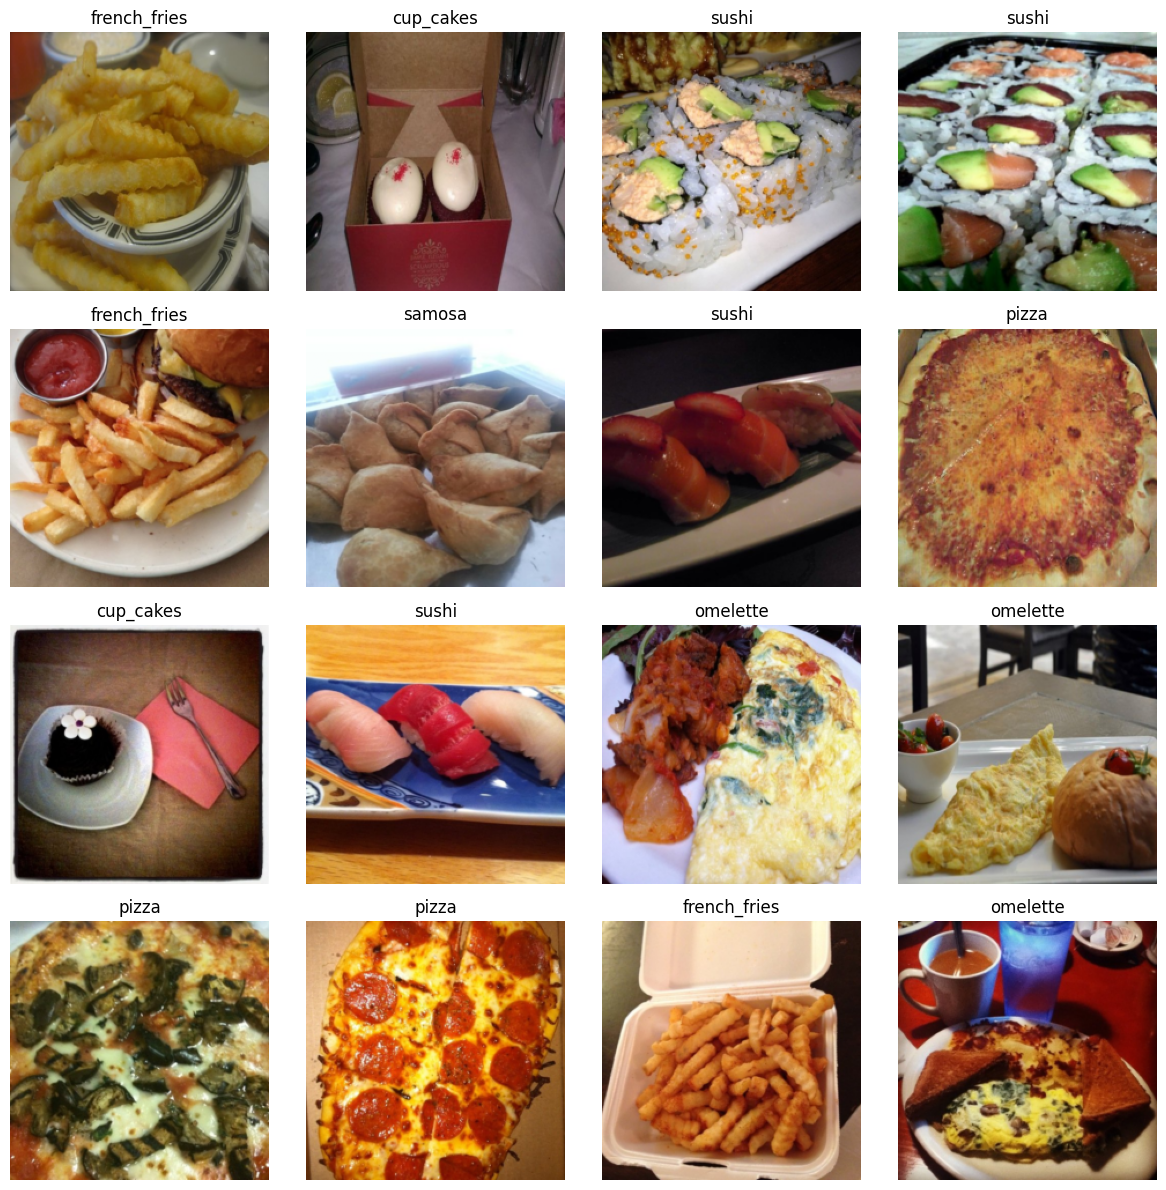

In [ ]:
torch.manual_seed(42)

fig = plt.figure(figsize=(12, 12))
rows, cols = 4,4


for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    img = img.permute(1, 2, 0)

    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

# **4. Data Splitting**

In [ ]:
raw_data = ImageFolder(train_dir)


train_size = int(0.8 * len(raw_data))
valid_size = len(raw_data) - train_size
train_subset, valid_subset = random_split(raw_data, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

# **5. Apply Data Augmentation**

In [ ]:
class TransformSubsets(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((int(IMG_SIZE * 1.14))),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = TransformSubsets(train_subset, train_transform)
valid_dataset = TransformSubsets(valid_subset, valid_test_transform)


test_dataset = ImageFolder(test_dir, transform=valid_test_transform)

# **6. Create Dataloaders**

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [ ]:
summary(model = model, input_size = (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# 7. **Freeze Feature-Extractor layers**

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

classifier.1.weight
classifier.1.bias


# 8. **Create the model**

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
out_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = out_shape)).to(device)

In [ ]:
summary(model = model,
        input_size = (32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 7]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3, weight_decay = 0.1)

# **9. Train Model**

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()
epochs = EPOCHS

#model=torch.compile(model)

results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device)


end_time = timer()
print(f"[INFO] Total training time is: {end_time-start_time:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.187 | train_acc: 68.51% | valid_loss: 0.818 | valid_acc: 82.12%
Epoch: 2 | train_loss: 0.848 | train_acc: 79.33% | valid_loss: 0.750 | valid_acc: 84.01%
Epoch: 3 | train_loss: 0.806 | train_acc: 80.45% | valid_loss: 0.730 | valid_acc: 83.82%
Epoch: 4 | train_loss: 0.789 | train_acc: 80.71% | valid_loss: 0.709 | valid_acc: 84.84%
Epoch: 5 | train_loss: 0.793 | train_acc: 80.71% | valid_loss: 0.720 | valid_acc: 84.11%
Epoch: 6 | train_loss: 0.794 | train_acc: 80.11% | valid_loss: 0.719 | valid_acc: 83.89%
Epoch: 7 | train_loss: 0.795 | train_acc: 80.07% | valid_loss: 0.724 | valid_acc: 84.11%
Epoch: 8 | train_loss: 0.786 | train_acc: 81.13% | valid_loss: 0.718 | valid_acc: 83.61%
Epoch: 9 | train_loss: 0.786 | train_acc: 80.61% | valid_loss: 0.712 | valid_acc: 84.01%
Epoch: 10 | train_loss: 0.794 | train_acc: 80.02% | valid_loss: 0.727 | valid_acc: 84.67%
Epoch: 11 | train_loss: 0.792 | train_acc: 80.33% | valid_loss: 0.708 | valid_acc: 84.65%
Epoch: 12 | train_l

# **10. Fine-Tuning**

In [ ]:
for param in model.features[-4:].parameters():
  param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5, weight_decay = 1e-3)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()
epochs = FINE_TUNE_EPOCHS

#model=torch.compile(model)

results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device)


end_time = timer()
print(f"[INFO] Total training time is: {end_time-start_time:.3f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.677 | train_acc: 83.81% | valid_loss: 0.548 | valid_acc: 87.63%
Epoch: 2 | train_loss: 0.557 | train_acc: 85.25% | valid_loss: 0.464 | valid_acc: 88.24%
Epoch: 3 | train_loss: 0.474 | train_acc: 87.33% | valid_loss: 0.402 | valid_acc: 88.93%
Epoch: 4 | train_loss: 0.415 | train_acc: 88.78% | valid_loss: 0.355 | valid_acc: 89.40%
Epoch: 5 | train_loss: 0.383 | train_acc: 89.56% | valid_loss: 0.341 | valid_acc: 90.25%
Epoch: 6 | train_loss: 0.348 | train_acc: 89.80% | valid_loss: 0.312 | valid_acc: 91.30%
Epoch: 7 | train_loss: 0.331 | train_acc: 90.22% | valid_loss: 0.287 | valid_acc: 91.27%
Epoch: 8 | train_loss: 0.290 | train_acc: 91.71% | valid_loss: 0.273 | valid_acc: 91.70%
Epoch: 9 | train_loss: 0.268 | train_acc: 92.09% | valid_loss: 0.259 | valid_acc: 91.96%
Epoch: 10 | train_loss: 0.258 | train_acc: 93.06% | valid_loss: 0.258 | valid_acc: 92.24%
Epoch: 11 | train_loss: 0.237 | train_acc: 93.39% | valid_loss: 0.241 | valid_acc: 92.53%
Epoch: 12 | train_l

# **11. Save the model**

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/my_model.pth")
print("Model Saved")

Model Saved


# **12. Model Evaluation on the test dataset**

In [ ]:
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[INFO] Finding all filepaths ending with '.jpg' in directory: /kaggle/input/foodvision-101-subset/test


[PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2545807.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/724405.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2138489.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/1501298.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2646189.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3270931.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3548404.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/1792519.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/568560.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3902864.jpg')]

## 12.1 Model predictions ***DataFrame***

In [ ]:
model_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = model,
                                     transform = valid_test_transform,
                                     class_names = class_names,
                                     device = "cpu")

  0%|          | 0/1750 [00:00<?, ?it/s]

In [ ]:
model_test_pred_df = pd.DataFrame(model_test_pred_dicts)
model_test_pred_df.head()

,image_path,class_name,pred_prob,pred_label,time_per_pred,correct
0,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9633,omelette,0.2312,True
1,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9610,omelette,0.0484,True
2,/kaggle/input/foodvision-101-subset/test/omele...,omelette,1.0000,omelette,0.0428,True
3,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9999,omelette,0.0429,True
4,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9789,omelette,0.0503,True


In [ ]:
model_test_pred_df.correct.value_counts()

correct
True     1656
False      94
Name: count, dtype: int64

## 12.2 **Model Evaluation with random samples**

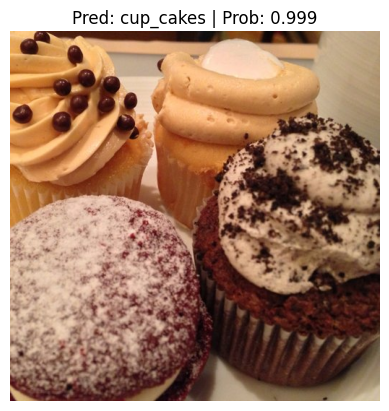

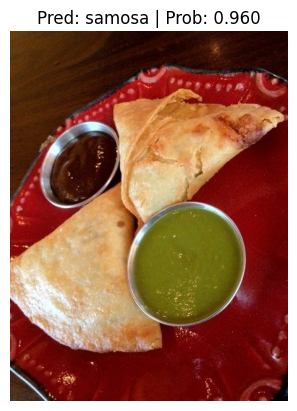

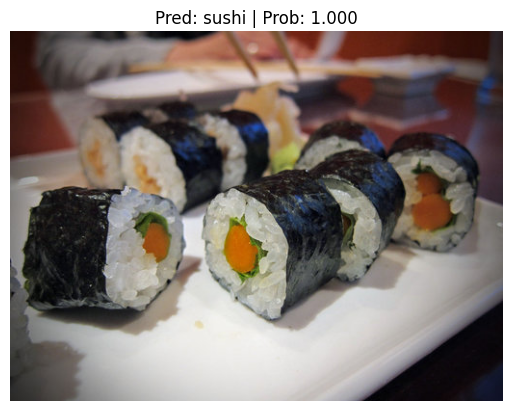

In [ ]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

for image_parg in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_parg,
                      class_names=class_names,
                      image_size=(224, 224))

In [ ]:
y_true, y_pred, y_probs = get_preds_and_labels(model, test_dataloader, device)

## 12.3 Classification Report

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cup_cakes       0.97      0.96      0.97       250
french_fries       0.96      1.00      0.98       250
    omelette       0.91      0.90      0.90       250
       pizza       0.95      0.97      0.96       250
      samosa       0.94      0.95      0.95       250
       steak       0.93      0.94      0.93       250
       sushi       0.97      0.91      0.94       250

    accuracy                           0.95      1750
   macro avg       0.95      0.95      0.95      1750
weighted avg       0.95      0.95      0.95      1750



## 12.4 Confusion Matrix

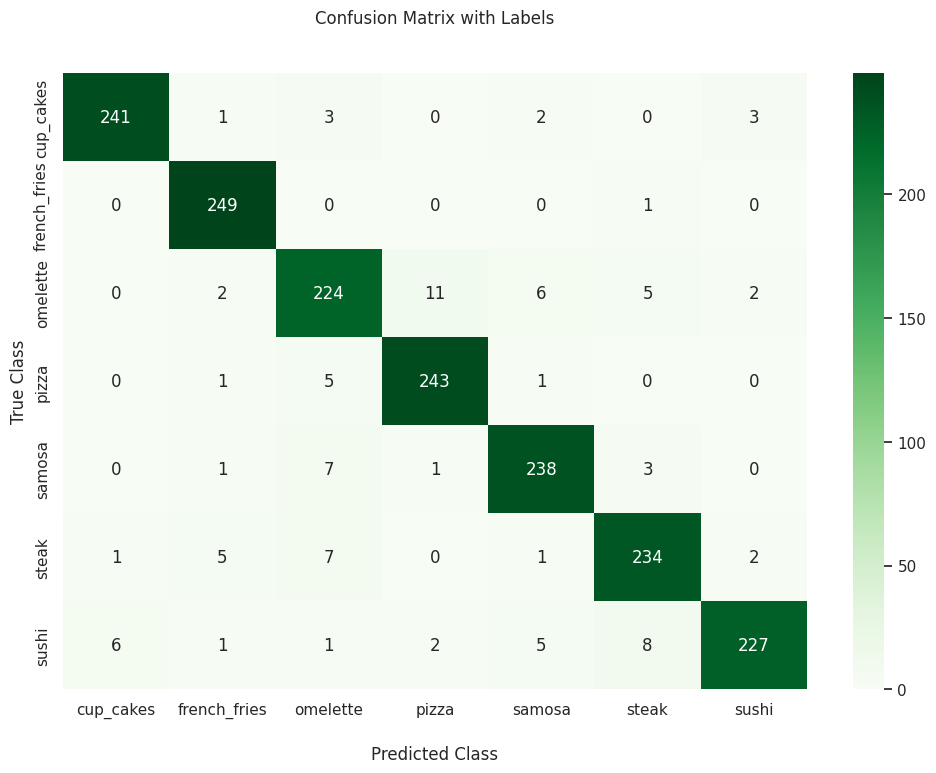

In [ ]:
confusionMatrix = confusion_matrix(y_true, y_pred)

sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.heatmap(confusionMatrix, annot=True, cmap='Greens', fmt='g')

ax.set_title('Confusion Matrix with Labels\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('True Class');

ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

plt.show()

# **13. Create a Gradio Demo**

In [ ]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 32.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.3 MB/s eta 0:00:00
Gradio version: 5.34.2


In [ ]:
#create a function to map inputs and outputs
model.to("cpu")
#check device
next(iter(model.parameters())).device

device(type='cpu')

In [ ]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

#randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

#open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")


#predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /kaggle/input/foodvision-101-subset/test/sushi/389730.jpg

Prediction label and probability dictionary: 
{'cup_cakes': 0.0006923266337253153, 'french_fries': 0.004648777190595865, 'omelette': 0.004819164518266916, 'pizza': 0.000364793639164418, 'samosa': 0.009532161056995392, 'steak': 0.001825130544602871, 'sushi': 0.9781176447868347}
prediction time: 0.04945 seconds


## 13.1 Create the Demo folder

In [ ]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=10)]
example_list

[['/kaggle/input/foodvision-101-subset/test/french_fries/2846402.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/french_fries/1580419.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/omelette/1942225.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/french_fries/1150103.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/samosa/910934.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/steak/3497585.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/cup_cakes/3685871.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/steak/2246332.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/sushi/3834718.jpg'],
 ['/kaggle/input/foodvision-101-subset/test/french_fries/2248373.jpg']]

In [ ]:
title = "FoodVision App🍕🍴"
description = "An Efficient Computer Vision Model to classify images for Food as Pizza, Steak and Sushi"
article = "Created at a Pytorch Course"

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type="pil"),
                    outputs = [gr.Label(num_top_classes=3, label="Predictoins"),
                               gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://246043b36f8de54bb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
foodvision_demo_path = Path("demos/foodvision/")

if foodvision_demo_path.exists():
  shutil.rmtree(foodvision_demo_path)
  foodvision_demo_path.mkdir(parents=True, exist_ok=True)

else:
  foodvision_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision/

## 13.2 Create the `Examples folder`

In [ ]:
foodvision_examples_path = foodvision_demo_path / "examples"
foodvision_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_examples = [Path('/kaggle/input/foodvision-101-subset/test/samosa/2988160.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/omelette/1243378.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/steak/3753767.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/sushi/1987407.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/sushi/192081.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/cup_cakes/2939333.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/french_fries/3310979.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/steak/1951003.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/sushi/1383396.jpg'),
                       Path('/kaggle/input/foodvision-101-subset/test/steak/3062369.jpg')]

for example in foodvision_examples:
  destination = foodvision_examples_path / example.name
  print(f"['INFO'] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

['INFO'] Copying /kaggle/input/foodvision-101-subset/test/samosa/2988160.jpg to demos/foodvision/examples/2988160.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/omelette/1243378.jpg to demos/foodvision/examples/1243378.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/steak/3753767.jpg to demos/foodvision/examples/3753767.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/sushi/1987407.jpg to demos/foodvision/examples/1987407.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/sushi/192081.jpg to demos/foodvision/examples/192081.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/cup_cakes/2939333.jpg to demos/foodvision/examples/2939333.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/french_fries/3310979.jpg to demos/foodvision/examples/3310979.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subset/test/steak/1951003.jpg to demos/foodvision/examples/1951003.jpg
['INFO'] Copying /kaggle/input/foodvision-101-subse

In [ ]:
example_list= [["examples/"+  example] for example in os.listdir(foodvision_examples_path)]
example_list

[['examples/3753767.jpg'],
 ['examples/1951003.jpg'],
 ['examples/1243378.jpg'],
 ['examples/2939333.jpg'],
 ['examples/192081.jpg'],
 ['examples/1383396.jpg'],
 ['examples/1987407.jpg'],
 ['examples/2988160.jpg'],
 ['examples/3062369.jpg'],
 ['examples/3310979.jpg']]

In [ ]:
model_foodvision_model_path = "/kaggle/working/my_model.pth"
model_foodvision_model_destination = foodvision_demo_path / Path(model_foodvision_model_path).name


try:
  print(f"[INFO] Attempting to move {model_foodvision_model_path} to {model_foodvision_model_destination}")

  shutil.move(src = model_foodvision_model_path,
              dst = model_foodvision_model_destination)
  print(f"[INFO] Model move complete")
except:
  print(f"[INFO] No model found at {model_foodvision_model_path}, perhaps it has already been moved")
  print(f"[INFO] Model exists at {model_foodvision_model_destination} : {model_foodvision_model_destination}")

[INFO] Attempting to move /kaggle/working/my_model.pth to demos/foodvision/my_model.pth
[INFO] Model move complete


## 13.3 Create `Model.py`

In [ ]:
%%writefile demos/foodvision/model.py
import torch
import torchvision
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

def create_model(num_classes: int, seed: int = 42):
    # Load pretrained weights and transforms
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()

    # Load base model
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze all base model layers
    for param in model.parameters():
        param.requires_grad = False

    # Set random seed
    torch.manual_seed(seed)

    # Update classifier head for your specific number of classes
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes)
    ).to(device)

    return model, transforms

Writing demos/foodvision/model.py


## 13.4 Create `app.py`

In [ ]:
%%writefile demos/foodvision/app.py

import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Define class names
class_names = ["cup_cakes", "french_fries", "omelette", "pizza", "samosa", "steak", "sushi"]

# Load model and transforms
model, model_transforms = create_model(num_classes=len(class_names))
model.load_state_dict(
    torch.load(
        f="my_model.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
    '''Transforms and performs a prediction on img and returns prediction and time taken'''
    # Start timer
    start_time = timer()

    # Transform the image and add batch dimension
    img = model_transforms(img).unsqueeze(0)

    # Evaluate mode and inference context
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)

    # Prepare predictions
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Time taken
    pred_time = round(timer() - start_time, 3)

    return pred_labels_and_probs, pred_time

# Gradio UI setup
title = "FoodVision App🍴"
description = "An Efficient Computer Vision Model to classify images for 7 types of food"
article = "Created with Python"

# Load examples
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=len(class_names), label="Predictions"),
        gr.Number(label="Prediction time (s)")
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch()

Writing demos/foodvision/app.py


## 13.5 Create `Requirements.txt`

In [ ]:
%%writefile demos/foodvision/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision/requirements.txt


## 13.6 Zip everything together!

In [ ]:
!cd demos/foodvision && zip -r ../foodvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/3753767.jpg (deflated 1%)
  adding: examples/1951003.jpg (deflated 0%)
  adding: examples/1243378.jpg (deflated 0%)
  adding: examples/2939333.jpg (deflated 0%)
  adding: examples/192081.jpg (deflated 0%)
  adding: examples/1383396.jpg (deflated 0%)
  adding: examples/1987407.jpg (deflated 0%)
  adding: examples/2988160.jpg (deflated 0%)
  adding: examples/3062369.jpg (deflated 1%)
  adding: examples/3310979.jpg (deflated 1%)
  adding: model.py (deflated 49%)
  adding: my_model.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [ ]:
!ls /kaggle/working/demos/foodvision

app.py	examples  model.py  my_model.pth  requirements.txt
